In [1]:
import gc
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from collections import Counter

pd.set_option('display.float_format', lambda x: '%.2f' % x)

/Users/eugeneshevchenko/Courses/RD_Computer-Vision/HW/.venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [2]:
DATASET_DIR = "../data/chest_xray/chest_xray"
DATASET_PATH = Path(DATASET_DIR)
IMG_SIZE = 240
CLASSES = ["NORMAL", "PNEUMONIA"]
ID_TO_CLASS = {0:'NORMAL', 1:'PNEUMONIA'}

In [3]:
def list_paths(split):
    paths, labels = [], []
    for i, c in enumerate(CLASSES):
        for p in (DATASET_PATH/split/c).glob("*"):
            if p.suffix.lower() in {".jpeg"}:
                paths.append(str(p)); labels.append(i)
    return tf.constant(paths), tf.constant(labels, dtype=tf.int32)

def load_native(path, y):
    img = tf.io.read_file(path)
    img = tf.io.decode_image(img, channels=1, expand_animations=False)
    img.set_shape([None, None, 1])
    return {"image": img, "path": path}, y

def load_split(split):
    paths, labels = list_paths(split)
    return tf.data.Dataset.from_tensor_slices((paths, labels)).map(load_native, num_parallel_calls=tf.data.AUTOTUNE)

In [7]:
train_ds = load_split("train")
val_ds = load_split("val")
test_ds = load_split("test")

all_ds = train_ds.concatenate(val_ds).concatenate(test_ds)

dataset_len = len(all_ds)

print("Train dataset len: ", len(train_ds))
print("Val dataset len:   ", len(val_ds))
print("Test dataset len:  ", len(test_ds))
print("Total dataset len: ", dataset_len)

Train dataset len:  5216
Val dataset len:    16
Test dataset len:   624
Total dataset len:  5856


We see the Validation Set is too small. So we will need to do something about that.

Maybe re-split the Test Set into Test & Validation.

In [8]:
class_ids = [int(y) for _, y in all_ds.as_numpy_iterator()]

In [9]:
def show_random_samples(ds, n=12, cols=6, title=""):
    random_samples = ds.shuffle(dataset_len).take(n).as_numpy_iterator()
    rows = (n + cols - 1) // cols
    plt.figure(figsize=(cols*5, rows*5))
    for i, (x, y) in enumerate(random_samples, 1):
        img = x["image"].squeeze(-1)
        h, w = img.shape
        label = ID_TO_CLASS[int(y)]
        plt.subplot(rows, cols, i)
        plt.imshow(img, cmap="gray")
        plt.title(f"{label} ({h}x{w})", fontsize=9)
        plt.axis("off")
        plt.gca().set_aspect('equal')

        del img, x, y

    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

    # Force garbage collection
    del random_samples
    gc.collect();

### Random sampling

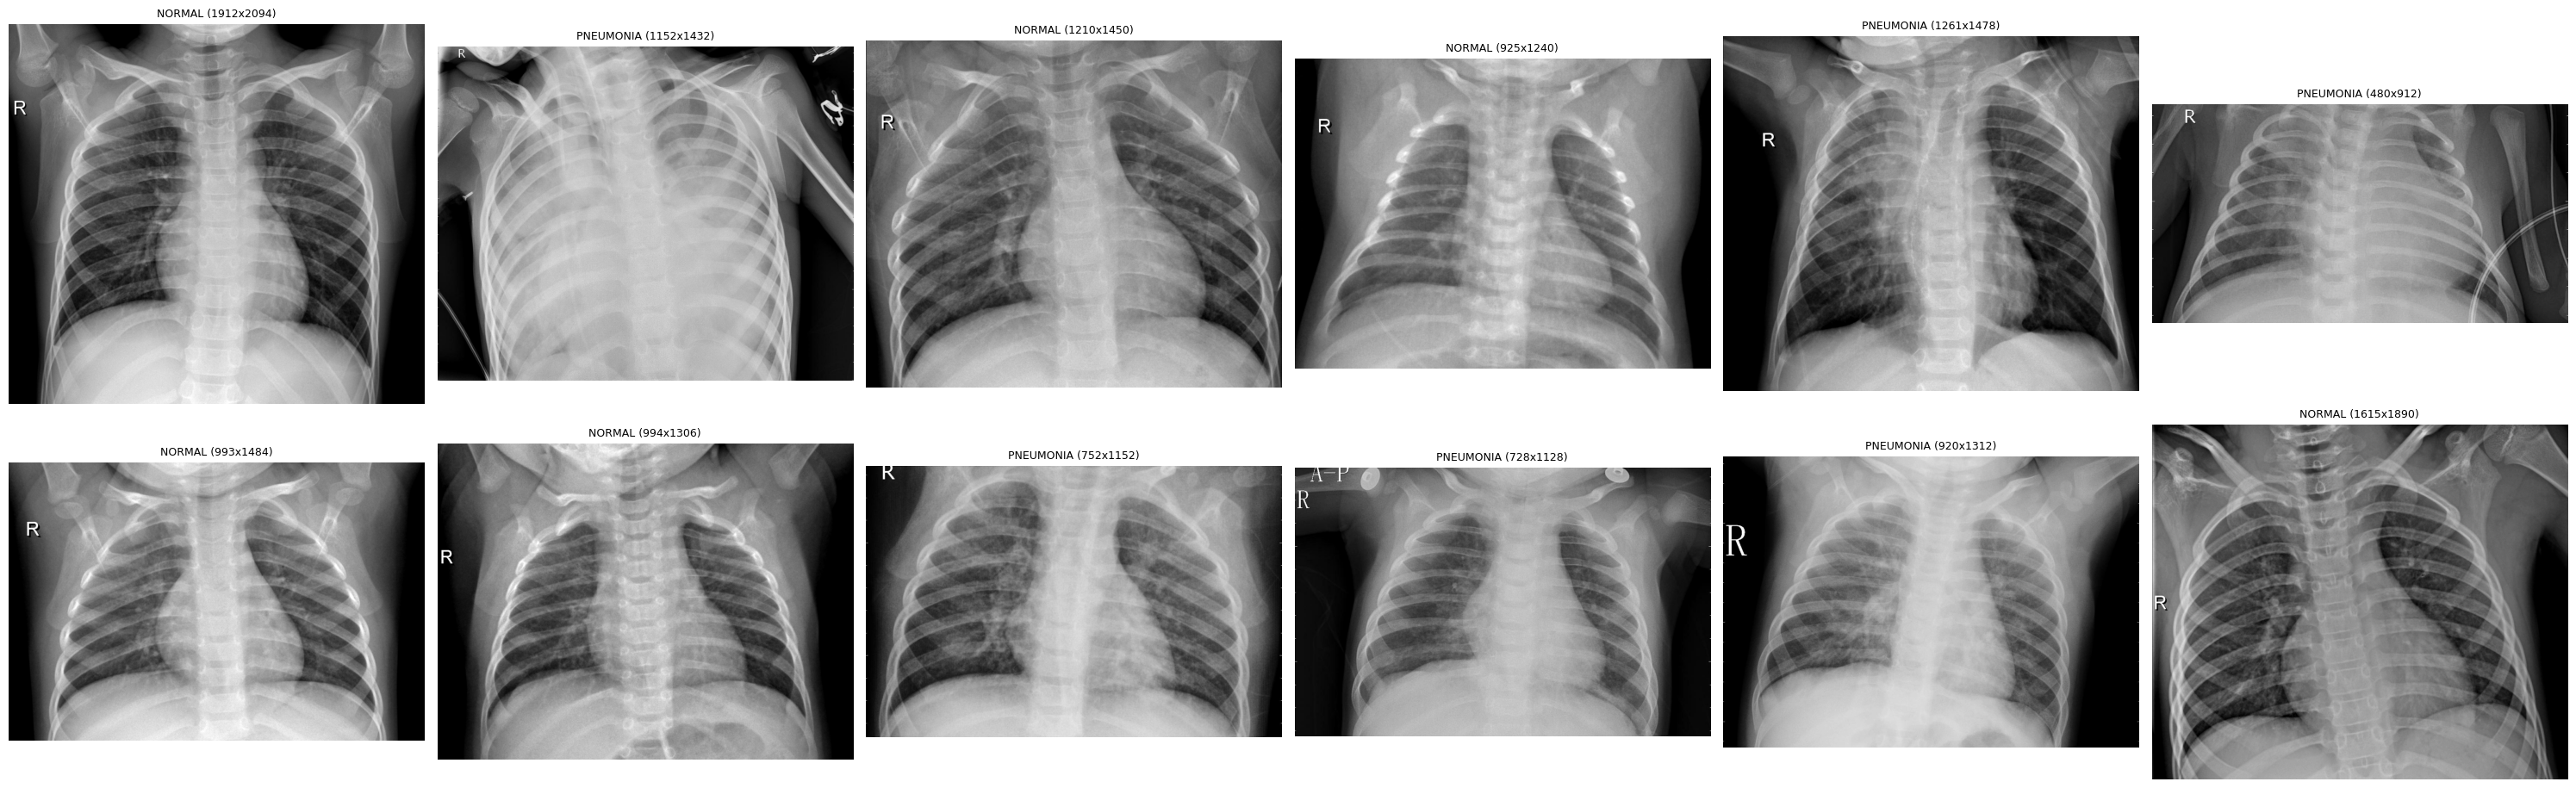

In [10]:
show_random_samples(all_ds, n=12, cols=6)

We see that images size vary. So we will need to apply some resizing strategy when building a model.

### Classes balance

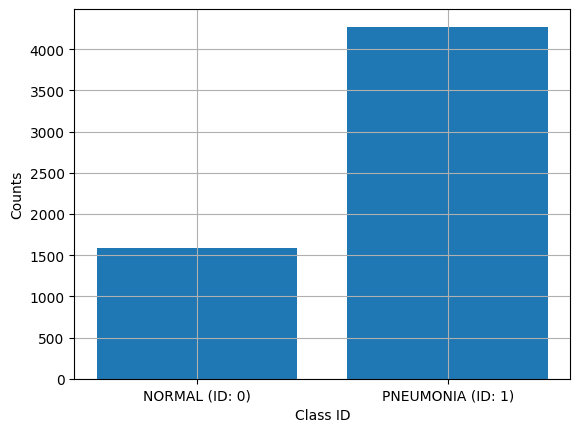

In [11]:
hist = Counter(class_ids)
hist_keys = hist.keys()

plt.bar(hist_keys, hist.values()), plt.grid(True)
plt.xticks(
    list(hist_keys),
    [str(ID_TO_CLASS[i]) + f" (ID: {i})" for i in hist_keys]
)
plt.xlabel('Class ID'), plt.ylabel('Counts');

The classes are imbalanced. We have almost 3 times more samples in the 2nd class (PNEUMONIA).

But it is not critical. More over there are more PNEUMONIA representatives, and our task to detect this class correctly.

### Analyze images size

In [12]:
image_info = []

for i, (x, y) in enumerate(all_ds.as_numpy_iterator(), 0):
    img = x["image"].squeeze(-1)
    h, w = img.shape
    cls_id = int(y)
    label = ID_TO_CLASS[cls_id]
    image_info.append((i, cls_id, label, w, h, w*h, w==h, h>w, w>h))
    # Free memory
    del img, x, y

df = pd.DataFrame(
    image_info,
    columns=['img_idx', 'cls_id', 'label', 'width', 'height', 'img_size', 'is_rect', 'is_portrait', 'is_landscape']
)
display(df.head())

# Force garbage collection
del image_info
gc.collect();

,img_idx,cls_id,label,width,height,img_size,is_rect,is_portrait,is_landscape
0,0,0,NORMAL,2359,2234,5270006,False,False,True
1,1,0,NORMAL,1422,1067,1517274,False,False,True
2,2,0,NORMAL,1828,1357,2480596,False,False,True
3,3,0,NORMAL,1854,1495,2771730,False,False,True
4,4,0,NORMAL,2194,1966,4313404,False,False,True


In [13]:
df.describe()

,img_idx,cls_id,width,height,img_size
count,5856.00,5856.00,5856.00,5856.00,5856.00
mean,2927.50,0.73,1327.88,970.69,1418908.82
std,1690.63,0.44,363.50,383.39,970443.12
min,0.00,0.00,384.00,127.00,48768.00
25%,1463.75,0.00,1056.00,688.00,727888.00
50%,2927.50,1.00,1281.00,888.00,1136928.00
75%,4391.25,1.00,1560.00,1187.00,1852074.00
max,5855.00,1.00,2916.00,2713.00,7532028.00


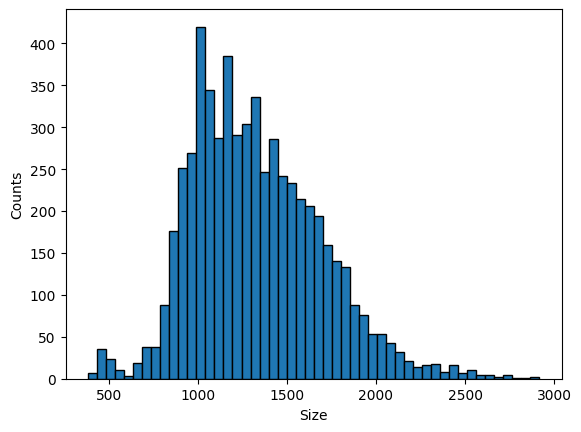

In [14]:
# Plot the resolution distribution
plt.hist(df.width, bins=50, edgecolor='black')
plt.xlabel('Size'), plt.ylabel('Counts');

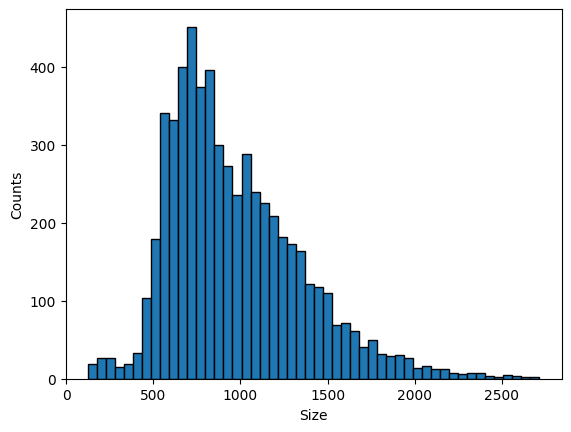

In [15]:
# Plot the resolution distribution
plt.hist(df.height, bins=50, edgecolor='black')
plt.xlabel('Size'), plt.ylabel('Counts');

Images size vary. We will apply some resizing strategy.